In [1]:
# needed on macs due to subtle multiprocessing differences used in dynesty
import sys
if sys.platform == 'darwin':
    import multiprocessing
    multiprocessing.set_start_method('fork')

In [1]:
import numpy as np

from scipy.special import lambertw

from astropy import units as u

from regions import CirclePixelRegion, PixCoord, RectanglePixelRegion, CirclePixelRegion, PolygonPixelRegion

import dynesty
from dynesty import plotting as dyplot

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

See [circular_exp_fitting](circular_exp_fitting.ipynb) for more backstory

In [3]:
BVAL = 1.6783469900166605 
TWOPI = 2*np.pi

(-8.0, 8.0)

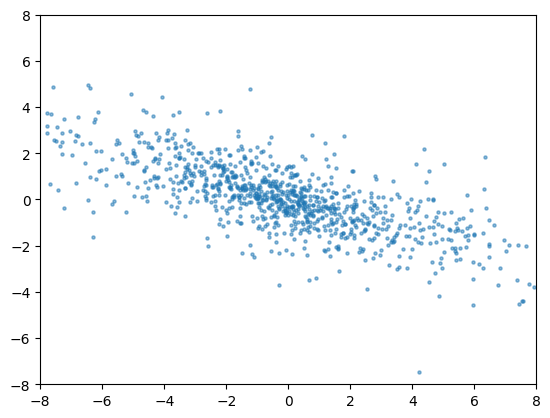

In [4]:
def generate_unif_box(n=None, halfsize=1, density=None, rstate=np.random.RandomState()):
    if n is not None and density is not None:
        raise ValueError('cannot give both n and density')
    elif density is not None:
        A = (halfsize*2)**2
        n = density * A
        
    if n != int(n):
        remainder = n - int(n)
        n = int(n)
        if np.random.rand(1)[0] < remainder:
            n += 1
    else:
        n = int(n)
        
    x = rstate.uniform(-halfsize, halfsize, n)
    y = rstate.uniform(-halfsize, halfsize, n)

    return x, y

def uniform_in_region(density, region, rstate=np.random.RandomState()):
    maxpx = np.max(region.bounding_box.extent)
    xs, ys = generate_unif_box(halfsize=maxpx, density=density, rstate=rstate)
    msk = region.contains(PixCoord(xs, ys))

    return xs[msk], ys[msk]

def expinteg(F, Re, b=BVAL):
    sc = np.isscalar(F)
    res = np.atleast_1d(-Re*(lambertw((F-1)/np.exp(1), -1).real + 1)/b)
    res.ravel()[np.isnan(res.ravel())] = 0
    return res[0] if sc else res
    

# this ellipticity is equivalent to the major axis being the "half-light" axis
def generate_exp_dglx(n=None, Re=1, pa=45*u.deg, ell=0, 
                      density=None, region=None, rstate=np.random.RandomState()):
    if n is not None and density is not None:
        raise ValueError('cannot give both n and density')
    elif density is not None:
        # density is the mean density within the HLR
        hA = np.pi*Re**2
        n = 2* density * hA
        
    if n != int(n):
        remainder = n - int(n)
        n = int(n)
        if np.random.rand(1)[0] < remainder:
            n += 1
    else:
        n = int(n)
        
    U = rstate.uniform(0, 1, n)
    r = expinteg(U, Re)
    phi = rstate.uniform(0, 2*np.pi, n)

    xp = np.cos(phi)*r
    yp = np.sin(phi)*r

    yp = yp/(1-ell)
    x = xp*np.cos(pa) - yp*np.sin(pa)
    y = xp*np.sin(pa) + yp*np.cos(pa)

    if region is not None:
        msk = region.contains(PixCoord(x, y))
        x = x[msk]
        y = y[msk]

    return x, y

plt.scatter(*generate_exp_dglx(1000, pa=70*u.deg, ell=.75), alpha=0.5, s=5)
plt.xlim(-8, 8)
plt.ylim(-8, 8)

In [5]:
def glx_and_uniform(glx_hdensity, bkg_density, region, Re=1, pa=45*u.deg, ell=0, rstate=np.random.RandomState()):
    g = generate_exp_dglx(density=glx_hdensity, Re=Re, pa=pa, ell=ell, region=region, rstate=rstate)
    b = uniform_in_region(bkg_density, region=region, rstate=rstate)

    return np.concatenate((g, b), axis=1), g, b

In [6]:
circular_large_reg = CirclePixelRegion(PixCoord(0, 0), 10)
circular_small_reg = CirclePixelRegion(PixCoord(0, 0), 3)
square_large_reg = RectanglePixelRegion(PixCoord(0, 0), 20, 20)
square_small_reg = RectanglePixelRegion(PixCoord(0, 0), 6, 6)
flattened_rect_large_reg = RectanglePixelRegion(PixCoord(0, 0), 20, 3)
flattened_rect_small_reg = RectanglePixelRegion(PixCoord(0, 0), 6, 1.5)

offset_poly_region = PolygonPixelRegion(PixCoord([-3, -3, 3, 3, 1, 1, -3], [2, -4, -4, 5, 5, 3, 2]))

all_regions = {nm: globals()[nm] for nm in 'circular_large_reg,circular_small_reg,square_large_reg,square_small_reg,flattened_rect_large_reg,flattened_rect_small_reg,offset_poly_region'.split(',')}

# Set up fitting code

`region` is a fixed region - if None the integrals are implied to infity.

Parameters:
* x0, y0 -> center
* Re -> half-light radius
* fbkg -> background fraction of all the stars

In [7]:
param_names = 'x0, y0, Re, fbkg, ell, pa'.split(', ')

Prior below is that x0, y0 are on U[-1, 1], Re is scale-free on [.01, 100], fbkg is U[.1, .9], ell is U[0, .8], pa is [0, pi]

In [8]:
uppri = 100
lpri = .01

def prior_transform(u):
    x = np.empty_like(u)
    x[:2] = u[:2]*2 -1
    x[2] = lpri**(1-u[2]) * uppri**u[2]
    x[3] = u[3]*.8 + .1
    x[4] = u[4]*.8
    x[5] = u[5]*180

    return x

In [9]:
test_region = circular_large_reg
test_data, tg, tb = glx_and_uniform(25, 2, ell=.5, pa=45*u.deg, region=test_region)
truths = [0, 0, 1, 
          len(tb[0])/(len(tb[0]) + len(tg[0])), 
          .5, 45]

len(tg[0]), len(tb[0]), truths[-1]

(157, 614, 45)

In [10]:
LTWOPI = np.log(TWOPI)

def loglike(p, data, area):
    x0, y0, Re, fbkg, ell, pa = p
    x, y = data

    α = Re/BVAL
    parad = np.radians(pa)

    dx = x - x0
    dy = y - y0

    xp =   dx*np.cos(parad) + dy*np.sin(parad)
    yp = (-dx*np.sin(parad) + dy*np.cos(parad))*(1 - ell)

    r = np.hypot(xp, yp)
    lgal = np.log(1-fbkg) - 2*np.log(α) - r/α - LTWOPI + np.log(1-ell)
    lbkg = np.log(fbkg/area)
    ll = np.logaddexp(lgal, lbkg)

    return np.sum(ll)
    

In [11]:
with dynesty.pool.Pool(16, loglike, prior_transform,
                                logl_kwargs={'data': test_data, 'area':test_region.area},
                      ) as pool:
    dsampler = dynesty.DynamicNestedSampler(pool.loglike, pool.prior_transform, pool=pool,
                                            ndim=len(param_names),sample='rslice')
    dsampler.run_nested(maxiter=100000,  wt_kwargs={'pfrac': 1.0})

16059it [00:14, 1100.59it/s, batch: 5 | bound: 11 | nc: 1 | ncall: 646988 | eff(%):  2.397 | loglstar: -4306.521 < -4300.451 < -4301.912 | logz: -4314.624 +/-  0.115 | stop:  0.982]    


/home/erik/.cache/pypoetry/virtualenvs/structparams-inference-biases-aTTQn185-py3.12/lib/python3.12/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


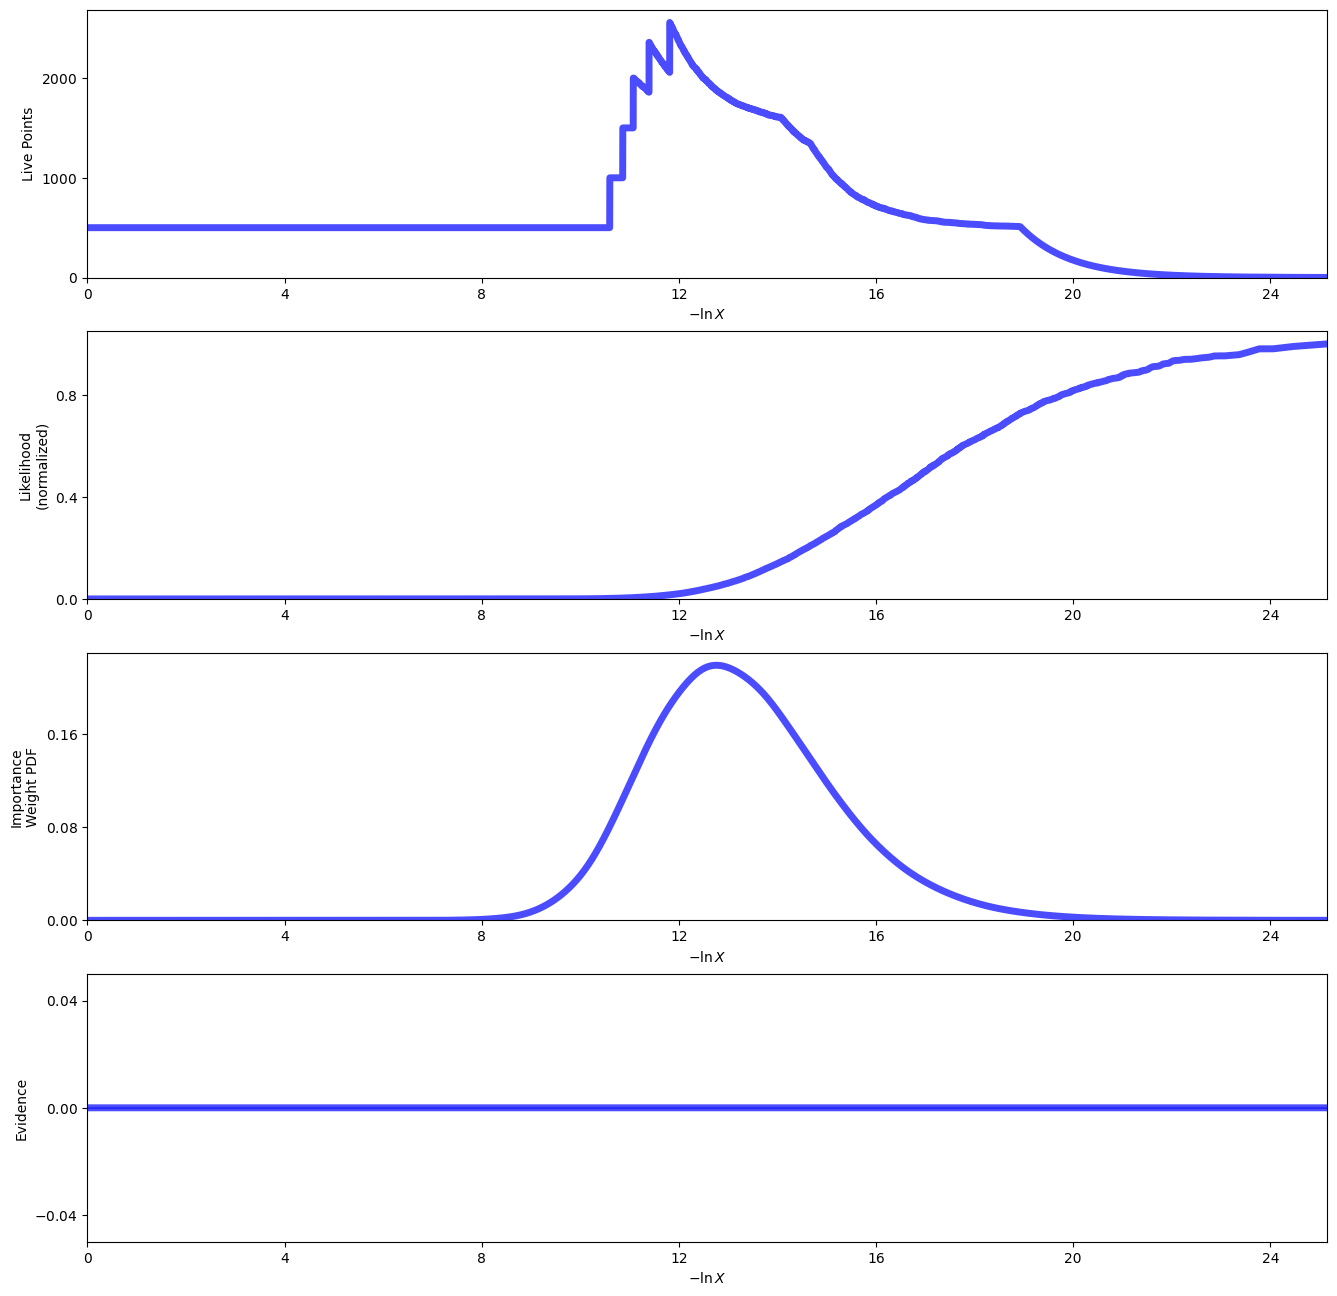

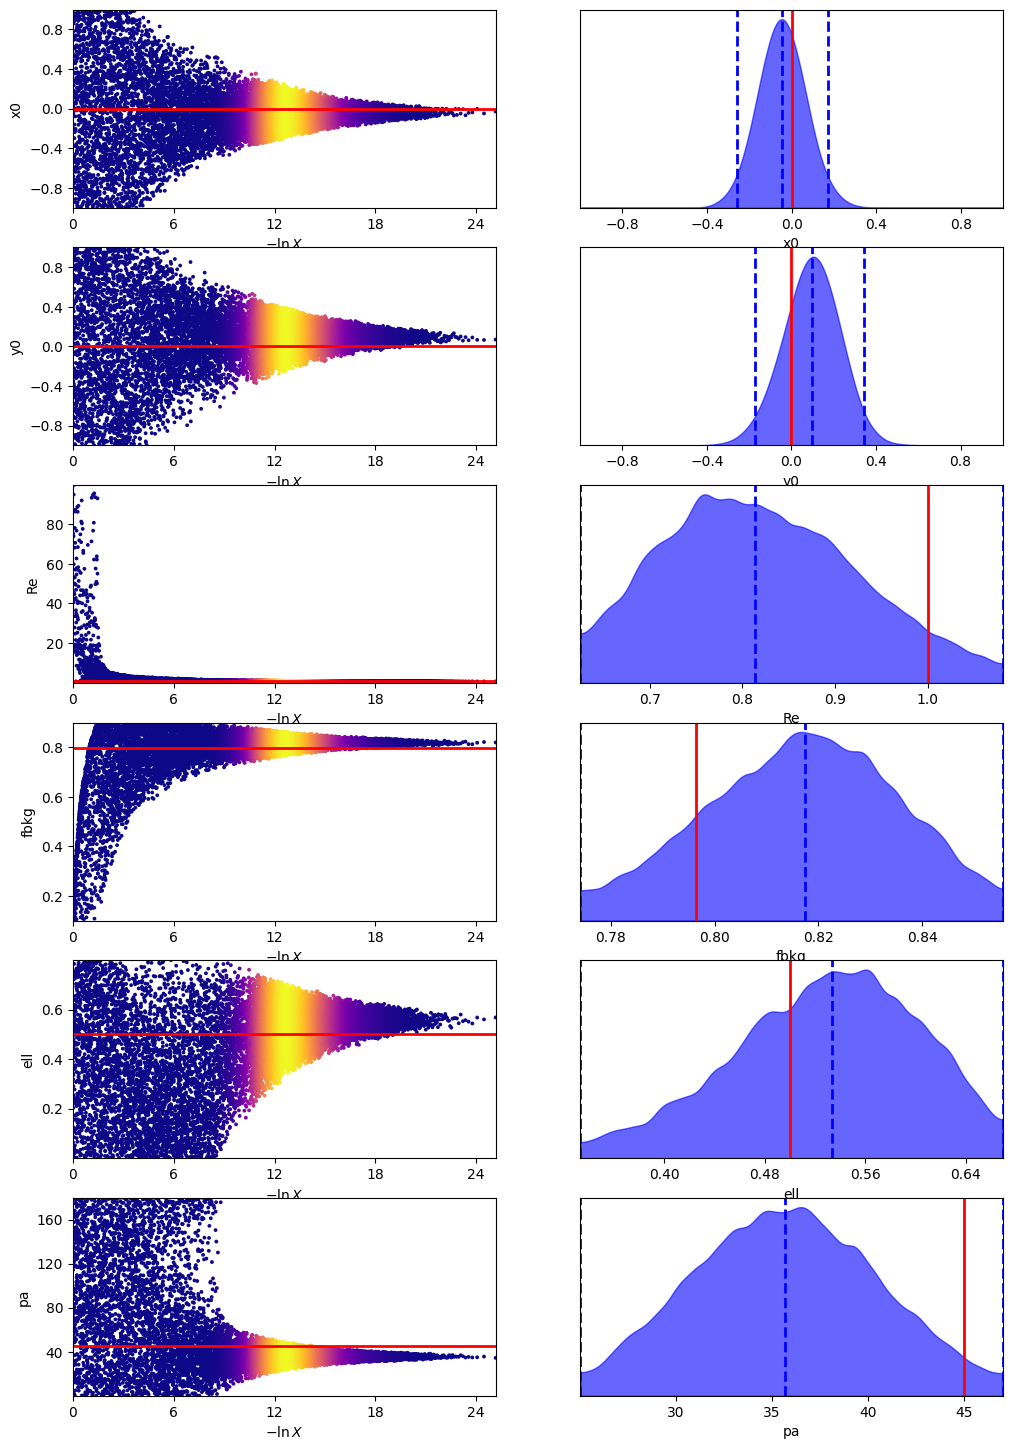

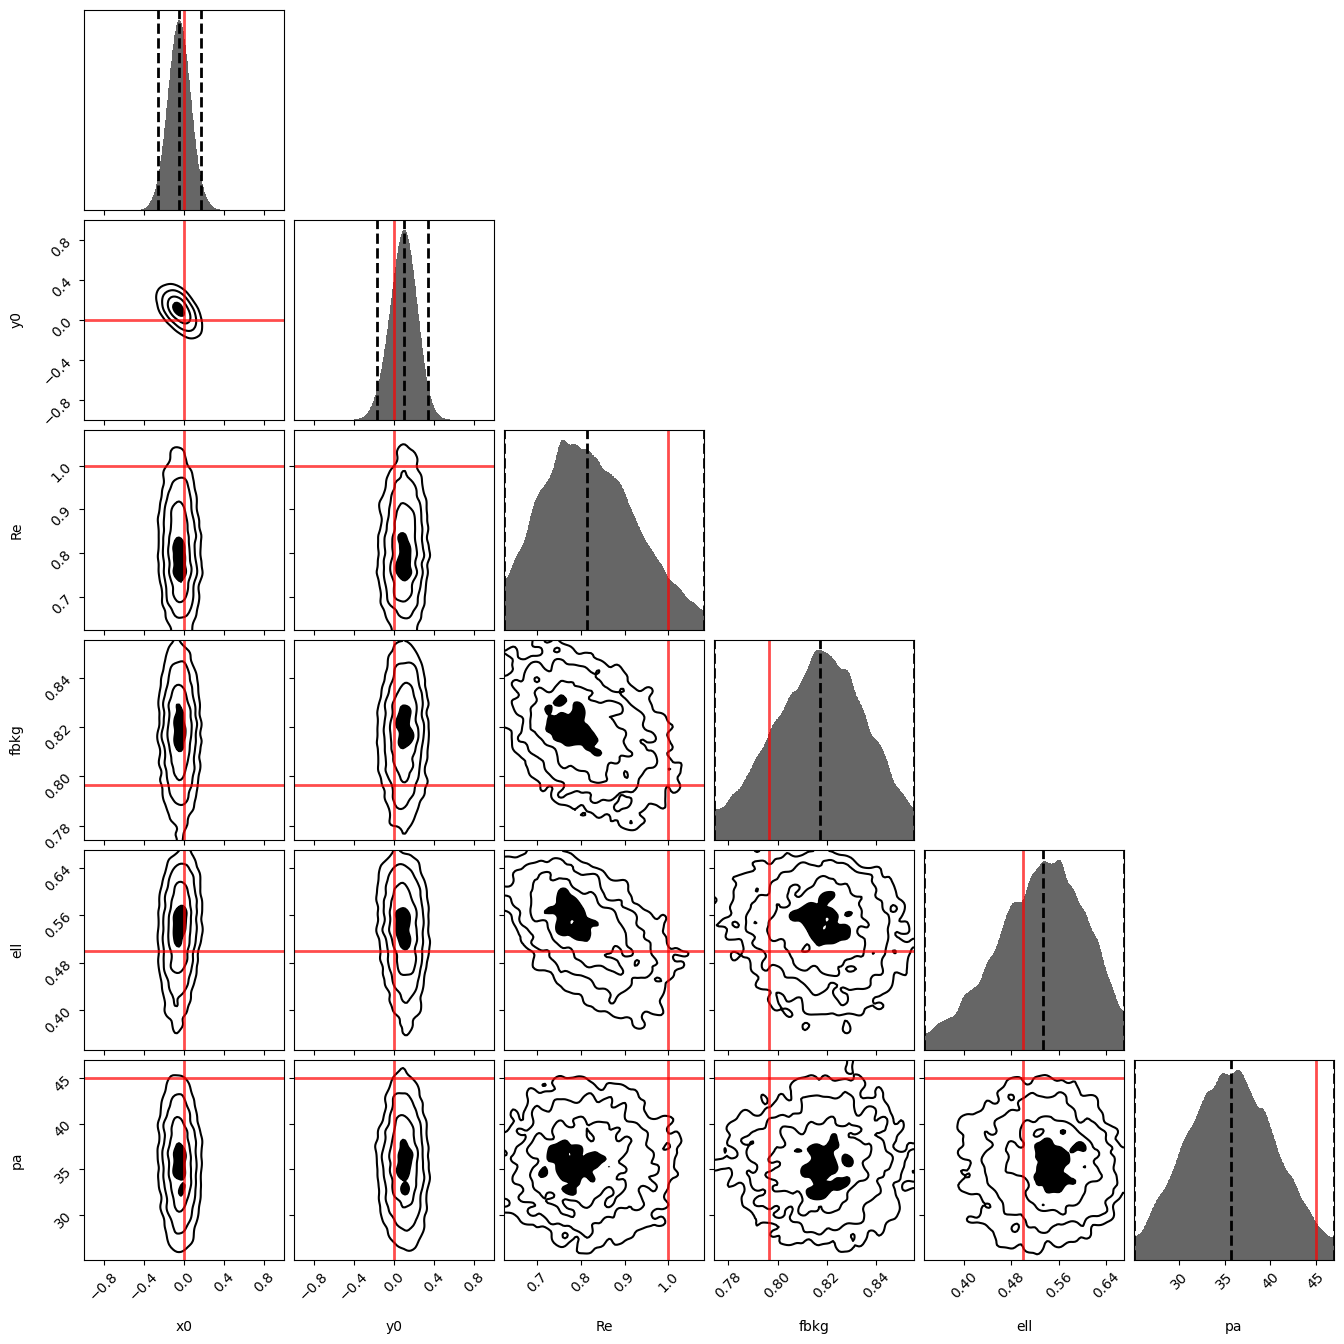

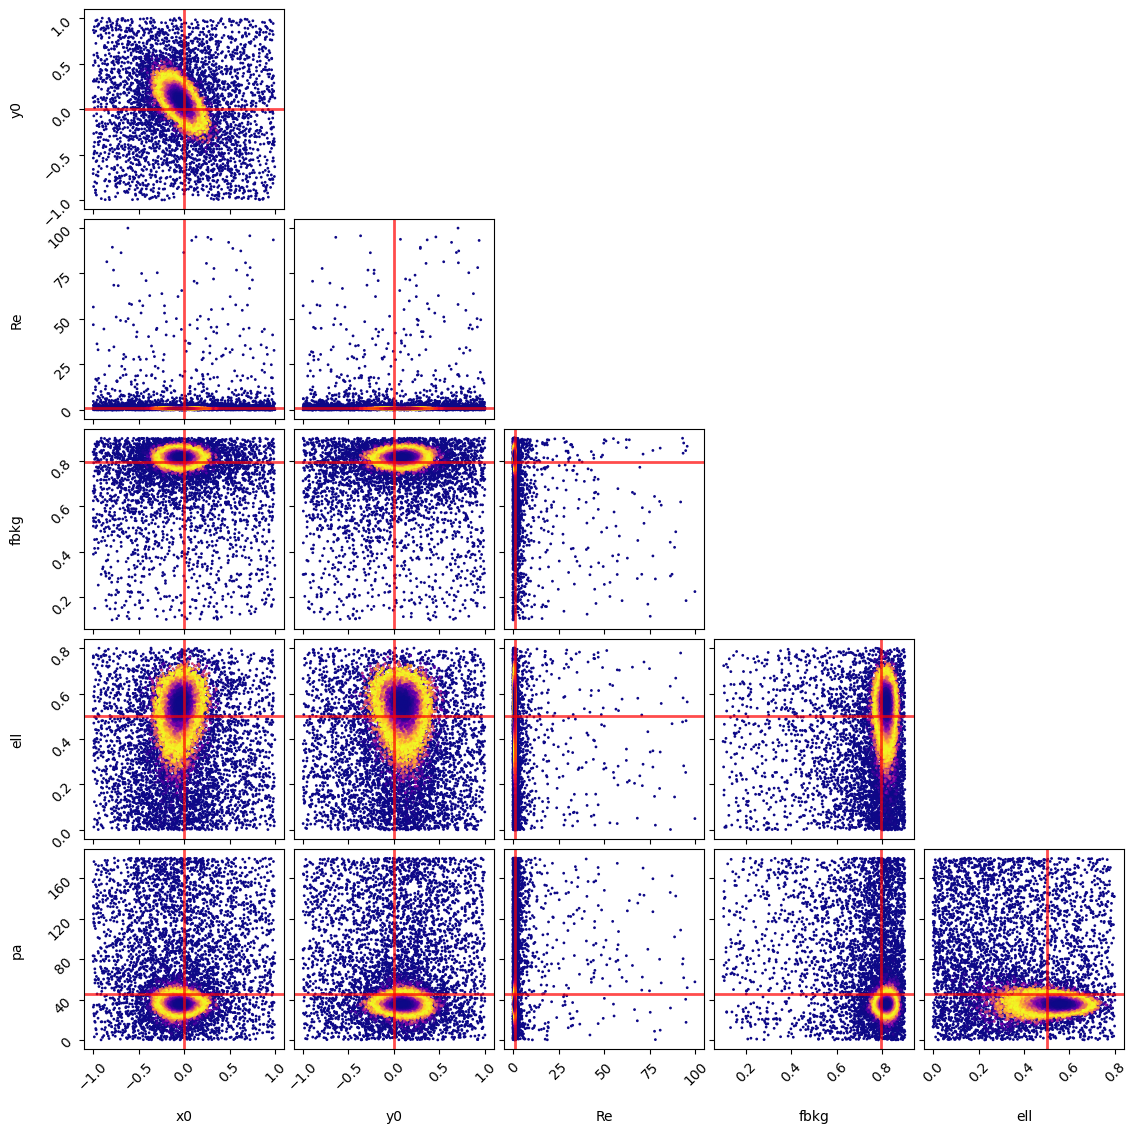

In [12]:
fig, axes = dyplot.runplot(dsampler.results)

span = [1,1, .95, .95, .95, .95]

fig, axes = dyplot.traceplot(dsampler.results, labels=param_names, truths=truths,span=span)
fig, axes = dyplot.cornerplot(dsampler.results, labels=param_names, truths=truths,span=span)
fig, axes = dyplot.cornerpoints(dsampler.results, labels=param_names, truths=truths)

In [13]:
results = {}
truths = {}
ell = .5
pa =  45*u.deg

for regnm, test_region in all_regions.items():
    print(regnm)
    
    test_data, tg, tb = glx_and_uniform(25, 2, region=test_region, ell=ell, pa=pa)
    print(len(tg[0]), len(tb[0]))
    truths[regnm] = [0, 0, 1, len(tb[0])/(len(tb[0]) + len(tg[0])), ell, pa.to_value(u.deg)]

    with dynesty.pool.Pool(16, loglike, prior_transform,
                                logl_kwargs={'data': test_data, 'area':test_region.area},
                      ) as pool:
        dsampler = dynesty.DynamicNestedSampler(pool.loglike, pool.prior_transform, pool=pool,
                                                ndim=len(param_names),sample='rslice')
        dsampler.run_nested(maxiter=100000,  wt_kwargs={'pfrac': 1.0})
    results[regnm] = dsampler.results

circular_large_reg
157 628


15977it [00:13, 1153.48it/s, batch: 5 | bound: 1 | nc: 1 | ncall: 641440 | eff(%):  2.405 | loglstar: -4387.909 < -4382.133 < -4387.451 | logz: -4394.953 +/-  0.101 | stop:  0.966]     


circular_small_reg
131 59


15130it [00:11, 1309.06it/s, batch: 4 | bound: 11 | nc: 1 | ncall: 603283 | eff(%):  2.416 | loglstar: -598.467 < -592.016 < -593.468 | logz: -604.635 +/-  0.108 | stop:  0.964]      

square_large_reg
158 788



16295it [00:16, 1000.83it/s, batch: 5 | bound: 14 | nc: 1 | ncall: 660507 | eff(%):  2.385 | loglstar: -5545.400 < -5538.981 < -5540.113 | logz: -5552.505 +/-  0.112 | stop:  0.937]    


square_small_reg
137 71


15407it [00:12, 1229.65it/s, batch: 5 | bound: 1 | nc: 1 | ncall: 617816 | eff(%):  2.405 | loglstar: -698.062 < -692.548 < -697.556 | logz: -704.577 +/-  0.098 | stop:  0.974]       

flattened_rect_large_reg
116 117



15678it [00:13, 1201.12it/s, batch: 5 | bound: 1 | nc: 1 | ncall: 628294 | eff(%):  2.408 | loglstar: -877.522 < -871.305 < -877.045 | logz: -884.380 +/-  0.102 | stop:  0.993]       

flattened_rect_small_reg
60 13



14308it [00:11, 1292.23it/s, batch: 3 | bound: 10 | nc: 1 | ncall: 574013 | eff(%):  2.395 | loglstar: -154.412 < -147.001 < -149.710 | logz: -159.063 +/-  0.107 | stop:  0.948]      

offset_poly_region
140 93



15995it [00:13, 1186.72it/s, batch: 5 | bound: 1 | nc: 1 | ncall: 643633 | eff(%):  2.400 | loglstar: -829.982 < -823.982 < -829.507 | logz: -836.974 +/-  0.101 | stop:  0.952]       


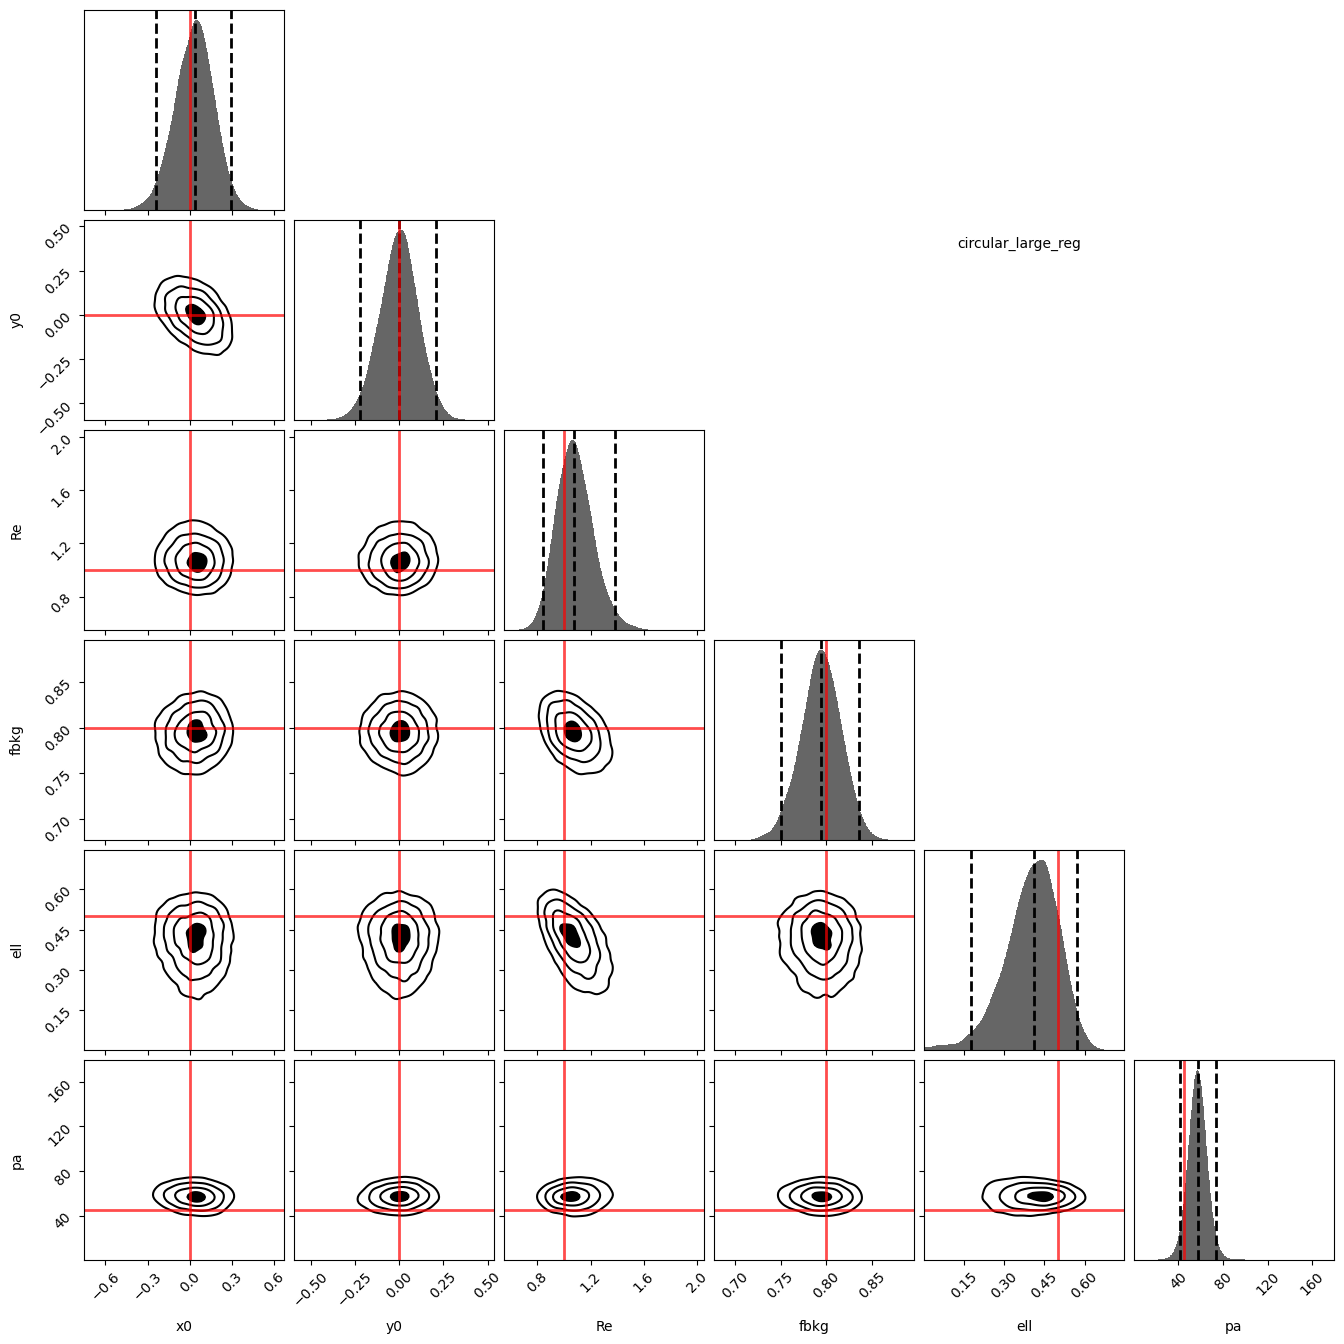

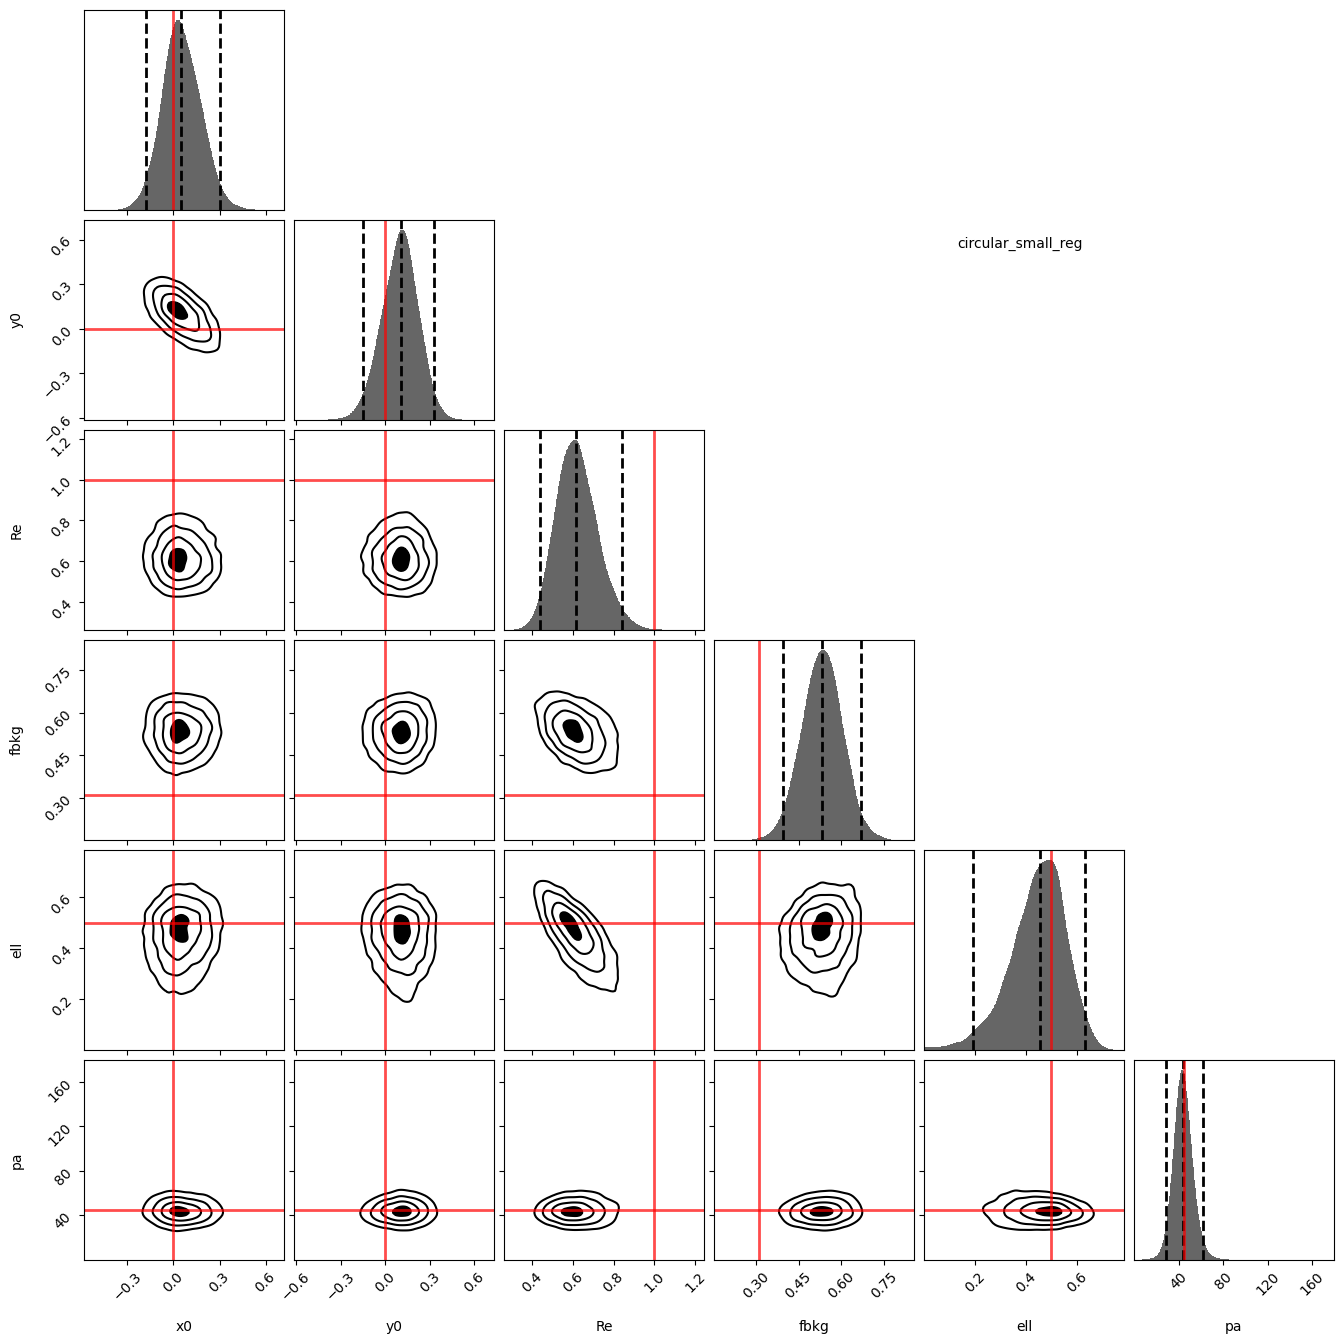

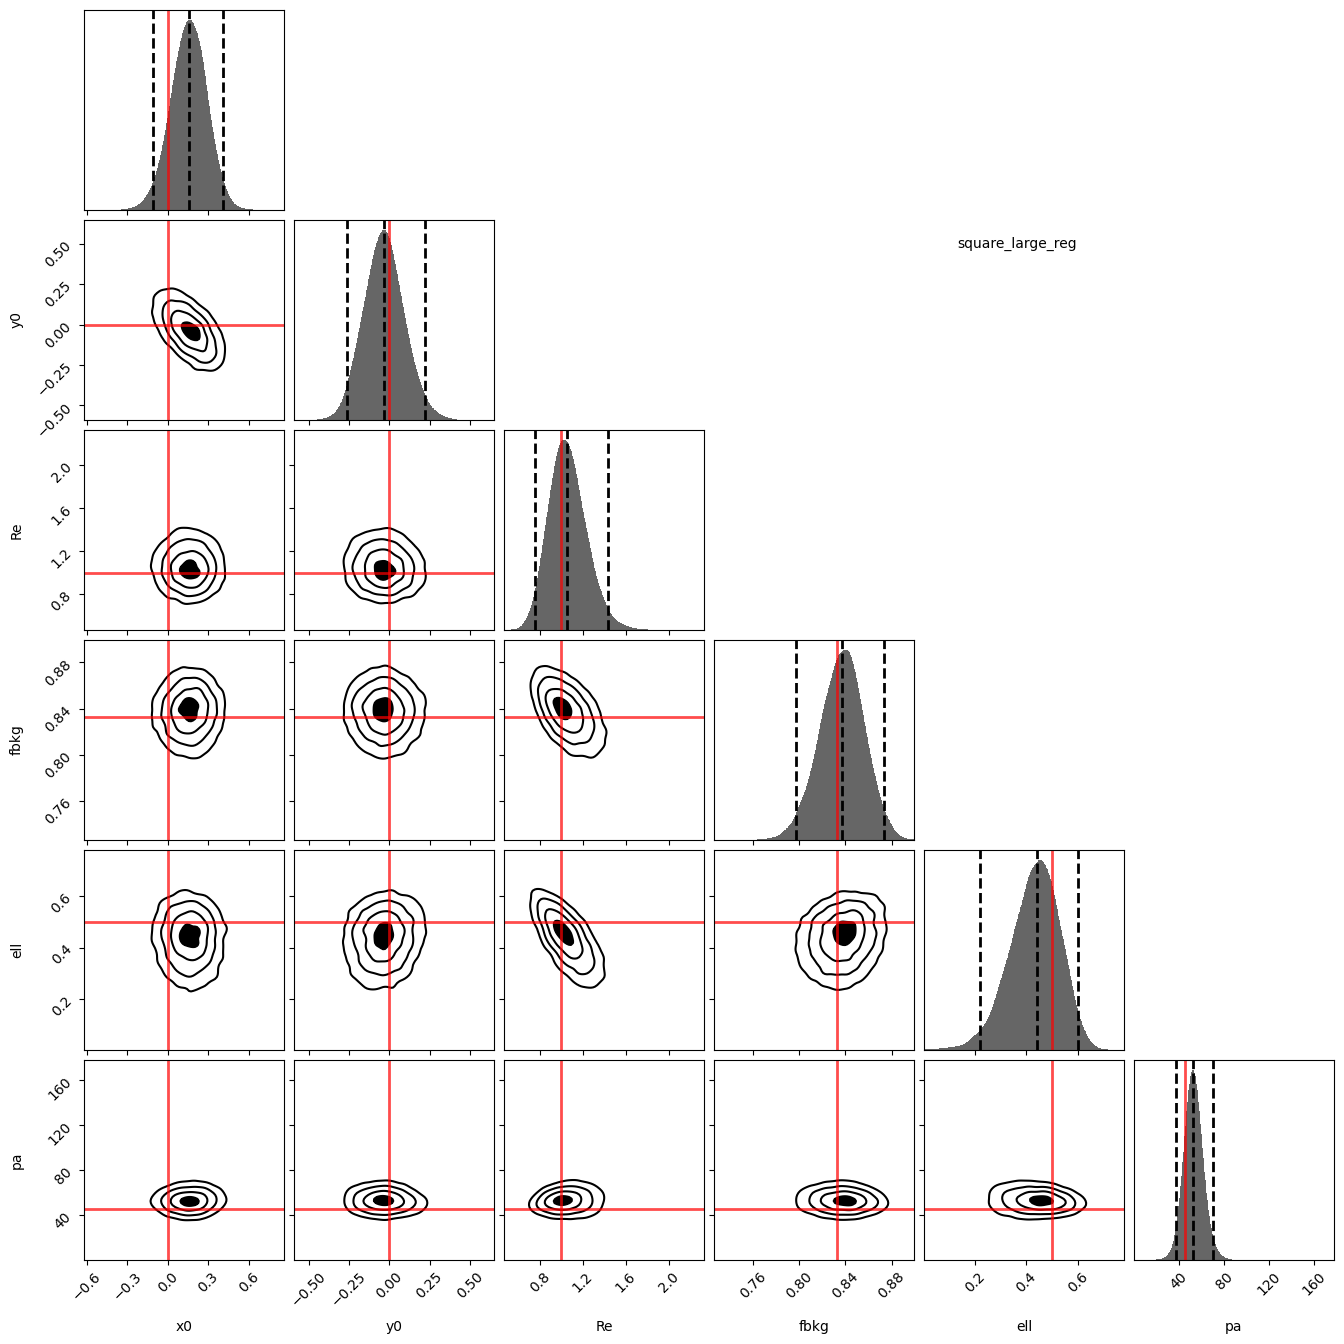

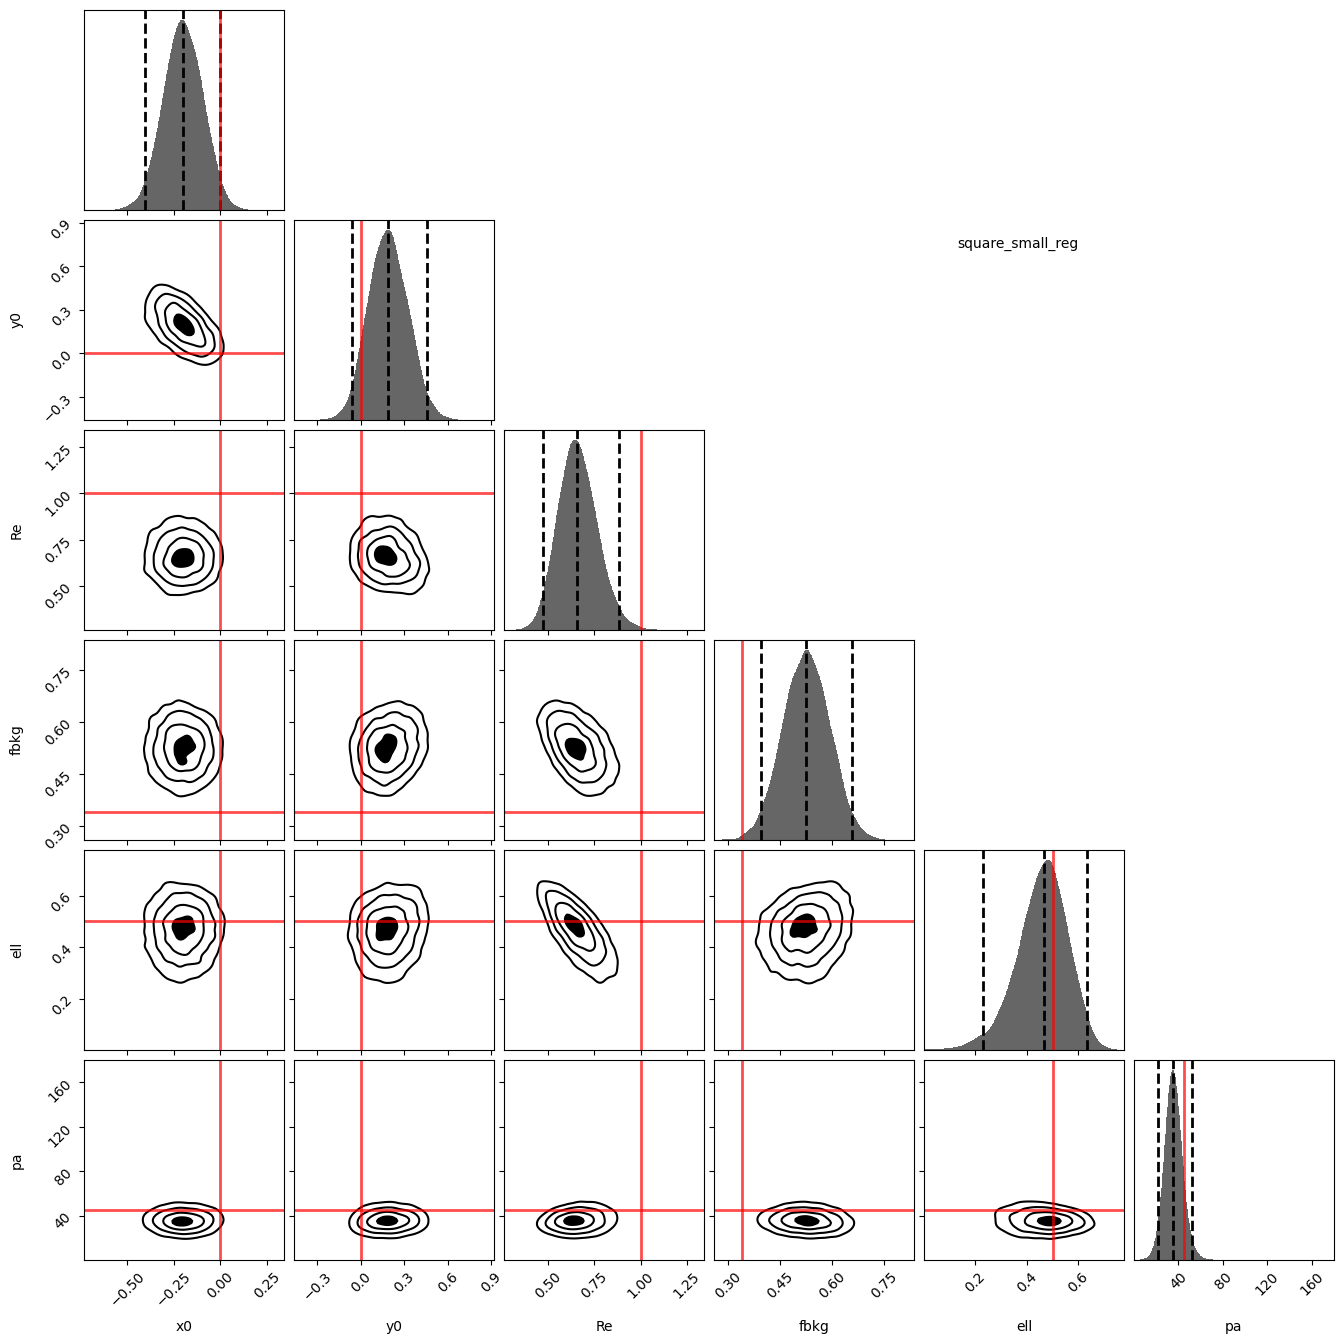

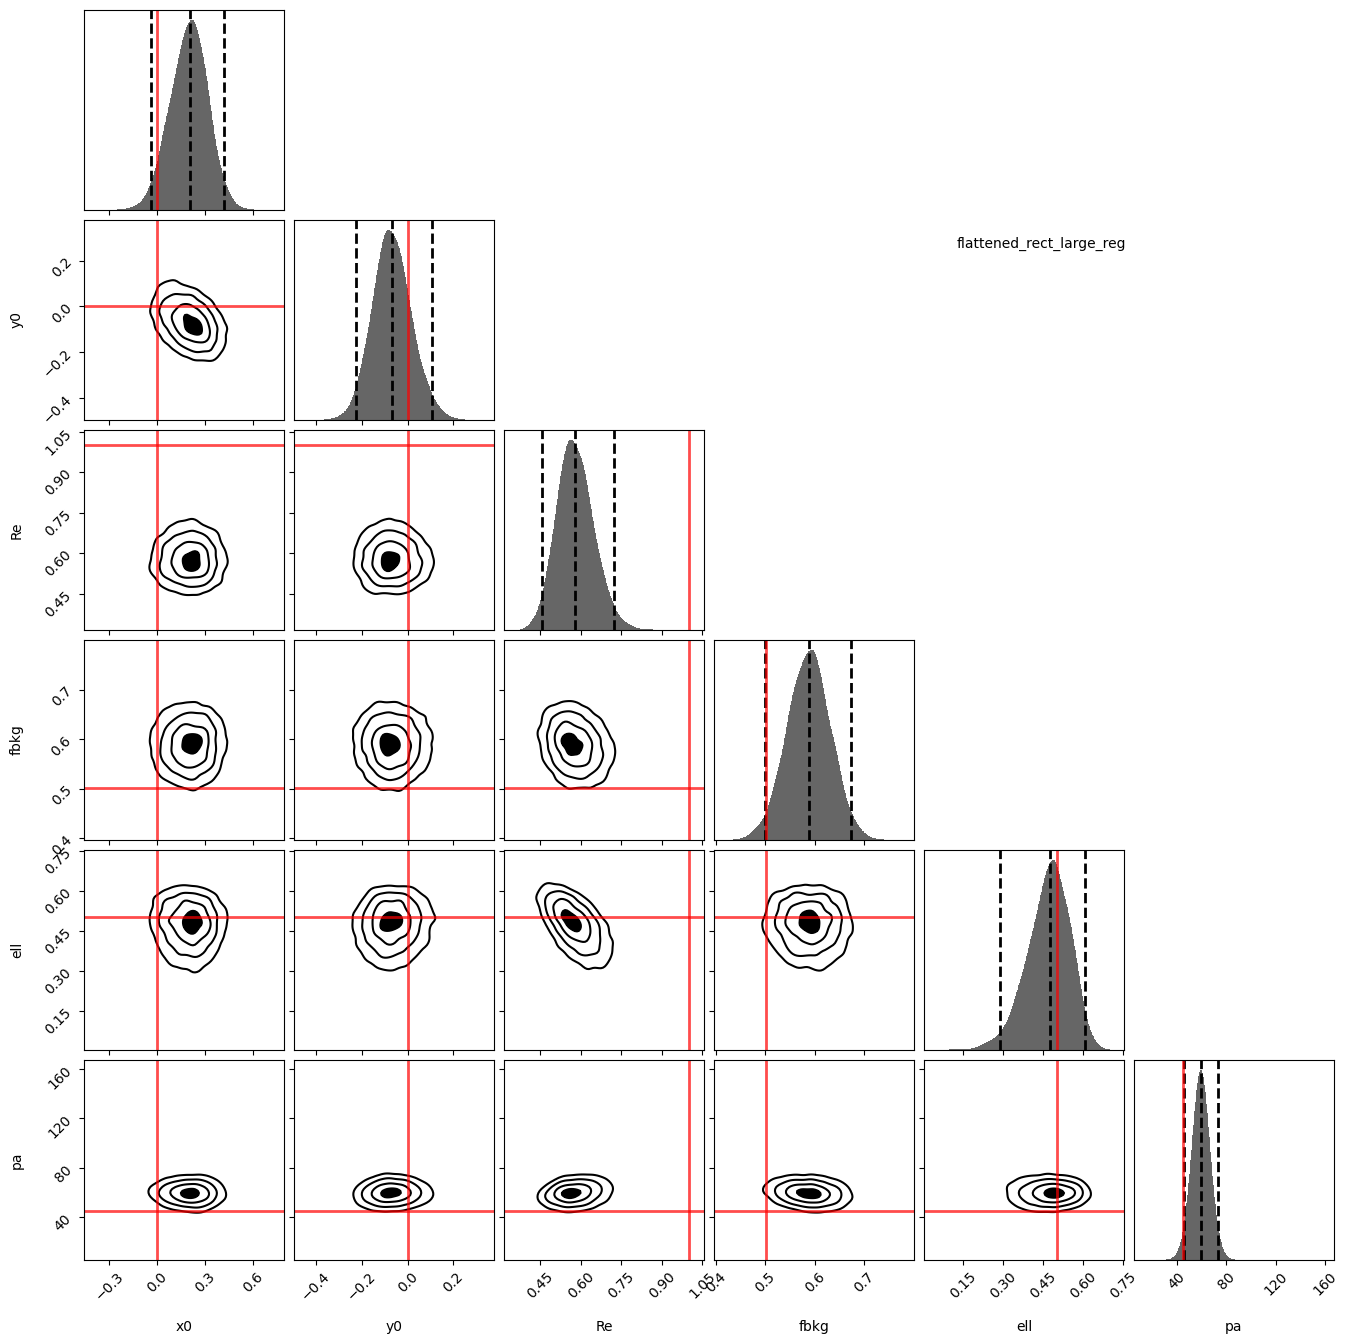

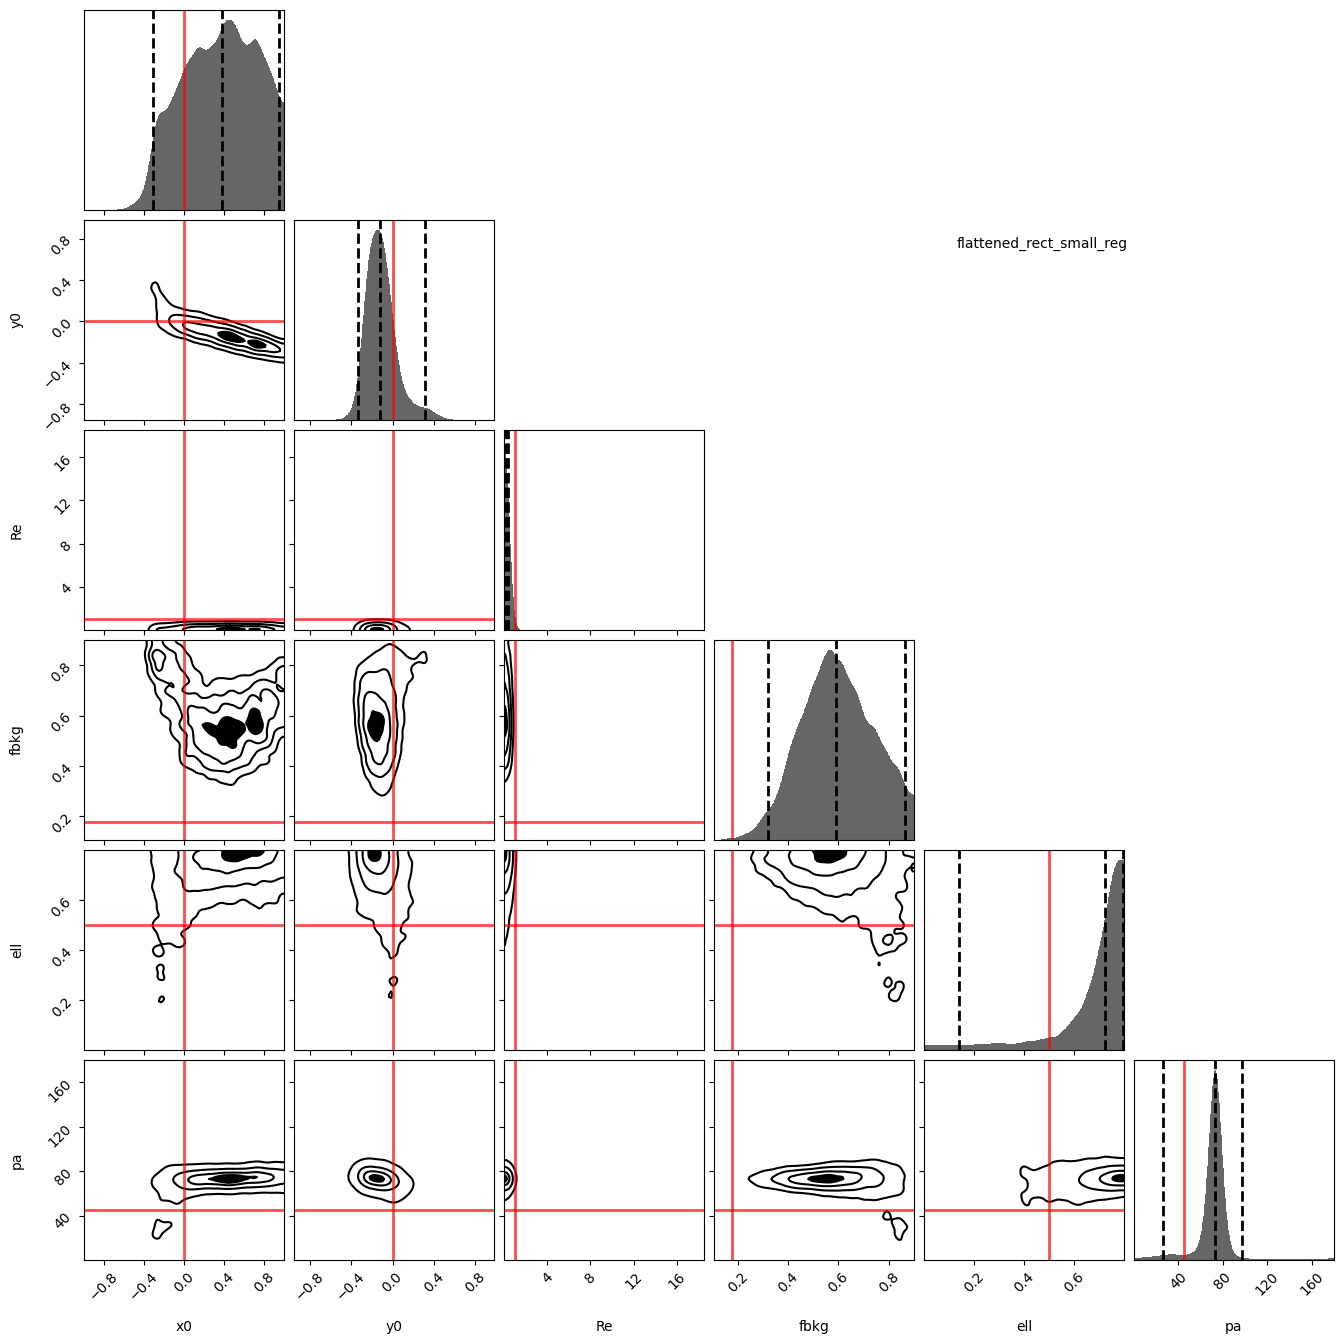

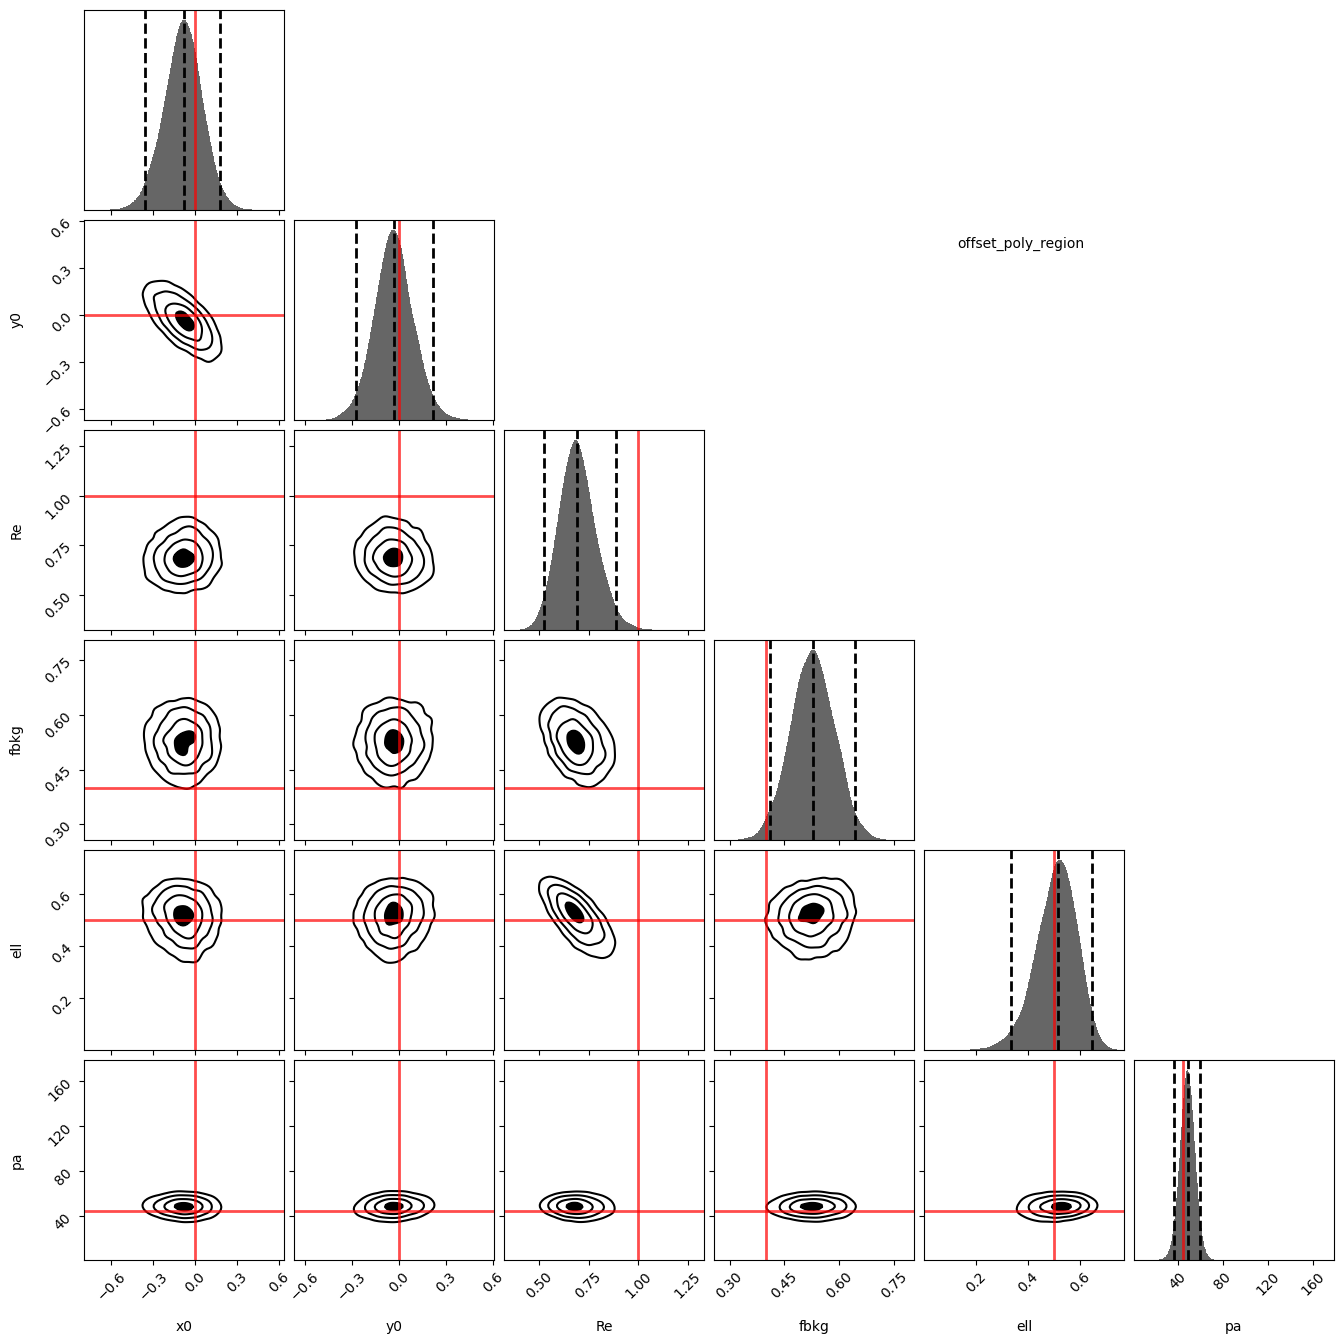

In [14]:
for nm, res in results.items():
    fig, axes = dyplot.cornerplot(res, labels=param_names, truths=truths[nm])
    axes[0][0].text(.7,.8, nm, transform=fig.transFigure)